In [1]:
# import numpy as np
# import re

# ptrn = (r'BLOCK: offset: (?P<offset>\d+) len: (?P<len>\d+) phased: (?P<phased>\d+) ' +
#                  r'SPAN: (?P<span>\d+) fragments (?P<fragments>\d+)')

# def parse_hap_file(fn):
#     with open(fn) as f:
#         for l in f:
#             if l.startswith('BLOCK'):
#                 g = re.match(ptrn, l)
#                 yield g.group('len')

# ema_blocks = np.fromiter(parse_hap_file('EMA_100pc-downsample-strelka2.hap'), int)
# bwa_blocks = np.fromiter(parse_hap_file('TruSeq_100pc-downsample-strelka2.hap'), int)


In [260]:
from cyvcf2 import VCF
from collections import defaultdict

def parse_vcf_file(fn):
    blocks = []
    
    current_ps = None
    for rec in VCF(fn):
        ps = None
        if 'PS' in rec.FORMAT:
            ps = rec.format('PS', int)[0][0]
        #print(ps, current_ps, ps == current_ps)
        if ps is not None and current_ps is not None and ps == current_ps:
            blocks[-1] += 1
        else:
            blocks.append(1)
            current_ps = ps
    return sorted(blocks, reverse=True)

ema_fn = 'examples/high_moderate_all/EMA_100pc.phased.vcf'
bwa_fn = 'examples/high_moderate_all/BWA_100pc.phased.vcf'

ema_blocks = parse_vcf_file(ema_fn)
bwa_blocks = parse_vcf_file(bwa_fn)

def parse_by_gene(fn):
    ps_by_gene = defaultdict(set)
    vars_by_gene = defaultdict(int)
    somatic_per_ps = defaultdict(int)
    germline_per_ps = defaultdict(int)
    
    for rec in VCF(fn):
        if 'ANN' in dict(rec.INFO):
            anns = rec.INFO['ANN'].split(',')
            genes_effected = set()
            for ann in anns:
                #C|upstream_gene_variant|MODIFIER|RNU6-291P|ENSG00000207451|transcript|ENST00000384720|snRNA||n.-831_-830delTT|||||831|,C
                _, _, impact, gene, _, _, _, region_type = ann.split('|')[:8]
                if impact in ['HIGH', 'MODERATE']:  
                    vars_by_gene[gene] += 1

                    ps = rec.format('PS', int)[0][0] if 'PS' in rec.FORMAT else None
                    ps_by_gene[gene].add(ps or rec.POS)
                    if ps:
                        if 'SOMATIC' in dict(rec.INFO):
                            somatic_per_ps[ps] += 1
                        else:
                            germline_per_ps[ps] += 1

                    break
    somatic_blocks = dict()
    for ps in somatic_per_ps.keys():
        somatic_blocks[ps] = somatic_per_ps[ps] + germline_per_ps[ps]
    
    return ps_by_gene, vars_by_gene, somatic_blocks
    
ema_ps_by_gene, ema_vars_by_gene, ema_somatic_blocks = parse_by_gene(ema_fn)
bwa_ps_by_gene, bwa_vars_by_gene, bwa_somatic_blocks = parse_by_gene(bwa_fn)


In [261]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")


In [262]:
print('Phasing blocks containing high-impact somatic variants. In 100 cancer genes')
print('EMA:', ema_somatic_blocks.values())
print('BWA:', bwa_somatic_blocks.values())
    
# plt.figure(figsize=(15, 8))
# ticks_num = 0
# for ps_by_gene, l in [(ema_somatic_blocks, "10x + EMA"), (bwa_somatic_blocks, "TruSeq + BWA-MEM")]:
#     x = sorted((cnt for cnt in ps_by_gene.values()), reverse=True)
#     ticks_num = max(ticks_num, x[0])
#     print(l, 'total somatic blocks:', len(x), '| variants in a block:', x)
#     ax = sns.distplot(x, label=l, kde=False, bins=x[0] - 1)

# # bins_labels(ticks_num)
# plt.xticks(ha='center')
# plt.xticks(np.arange(ticks_num))
# plt.xlabel('# variants')
# plt.ylabel('# blocks')
# plt.title('Phasing blocks containing high-impact somatic variants. In 100 cancer genes')
# plt.legend()
# pass

current_palette = sns.color_palette()
print(sns.color_palette("hls", 8))

Phasing blocks containing high-impact somatic variants. In 100 cancer genes
EMA: dict_values([2, 17, 5, 3, 3, 3, 3, 2, 2, 3, 36, 4, 3, 2, 4, 3, 3, 2, 2, 2, 6, 2, 2, 5, 18, 6, 4, 2, 3, 4, 7, 8, 11, 2, 2, 2, 23, 3, 2, 15, 10, 2, 4, 4, 3, 7, 14, 4, 4, 3, 4])
BWA: dict_values([6, 4, 2, 2, 2, 2, 2, 2, 3, 3, 2])
[(0.85999999999999999, 0.37119999999999997, 0.33999999999999997), (0.85999999999999999, 0.7612000000000001, 0.33999999999999997), (0.56880000000000008, 0.85999999999999999, 0.33999999999999997), (0.33999999999999997, 0.85999999999999999, 0.50120000000000009), (0.33999999999999997, 0.82879999999999987, 0.85999999999999999), (0.33999999999999997, 0.43879999999999986, 0.85999999999999999), (0.63119999999999976, 0.33999999999999997, 0.85999999999999999), (0.85999999999999999, 0.33999999999999997, 0.69879999999999964)]


# Phased groups per gene, high+moderate germline+somatic in 100 genes

10x + EMA total genes: 7053 | phased blocks distribution: [193, 67, 57, 51, 47, 47, 42, 42, 40, 35, 32, 32, 30, 29, 28, 26, 23, 21, 20, 19, 19, 19, 18, 16, 16, 16, 16, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 13, 13, 13, 13, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7] | mean blocks per gene: 1.66156245569
TruSeq + BWA-MEM total genes: 6760 | phased blocks distribution: [196, 94, 92, 66, 57, 55, 55, 54, 52, 44, 42, 39, 34, 32, 32, 31, 30, 29, 28, 28, 27, 25, 25, 21, 20, 20, 20, 20, 19, 19, 19, 18, 18, 18, 17, 17, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9] | mean blocks per gene: 1.92455621302


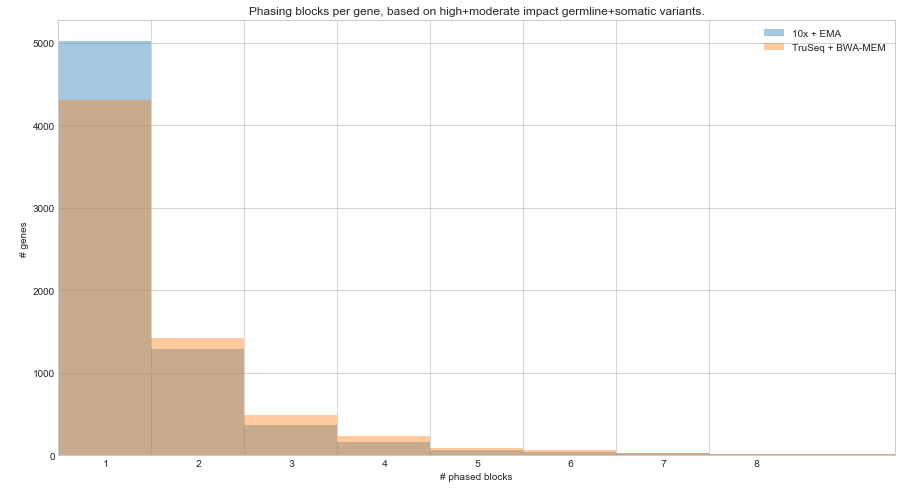

In [268]:
plt.figure(figsize=(15, 8))

ticks_num = 0
for ps_by_gene, l in [(ema_ps_by_gene, "10x + EMA"), (bwa_ps_by_gene, "TruSeq + BWA-MEM")]:
    x = sorted((len(ps) for ps in ps_by_gene.values()), reverse=True)
    ticks_num = max(ticks_num, x[0])
    print(l, 'total genes:', len(x), '| phased blocks distribution:', x[:100], '| mean blocks per gene:', np.mean(x))
    ax = sns.distplot(x, label=l, kde=False, bins=x[0] - 1)

plt.xticks(np.arange(0, 9), [' '*35 + f'{x}' for x in range(10)])
plt.xlim(1, 10)
plt.xlabel('# phased blocks')
plt.ylabel('# genes')
plt.title('Phasing blocks per gene, based on high+moderate impact germline+somatic variants.')
plt.legend()
pass

# Var per gene, high+moderate germline+somatic in 100 genes

10x + EMA, variants total genes: 7053 | distribution: [196, 145, 128, 82, 78, 73, 70, 67, 60, 59, 56, 56, 54, 49, 48, 43, 43, 42, 42, 40, 40, 34, 33, 32, 31, 30, 30, 29, 29, 28, 26, 25, 25, 25, 25, 25, 23, 23, 22, 22, 21, 21, 21, 20, 20, 19, 19, 19, 19, 19, 19, 18, 18, 18, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12] | mean variants per gene: 2.18006522047
TruSeq + BWA-MEM, variants total genes: 6760 | distribution: [197, 143, 128, 83, 75, 75, 72, 65, 57, 56, 56, 55, 53, 48, 43, 42, 41, 41, 40, 40, 39, 34, 33, 31, 31, 29, 28, 28, 28, 28, 26, 25, 25, 25, 24, 23, 22, 22, 22, 21, 21, 21, 20, 20, 19, 19, 19, 19, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 17, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12] | mean variants per gene: 2.184763313

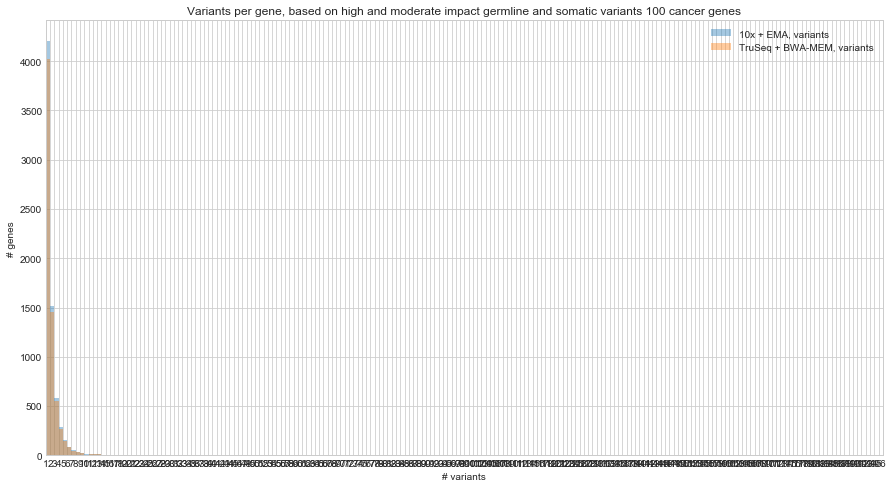

In [265]:
plt.figure(figsize=(15,8))

ticks_num = 0
for vars_by_gene, l in [(ema_vars_by_gene, "10x + EMA, variants"), (bwa_vars_by_gene, "TruSeq + BWA-MEM, variants")]:
    x = sorted((vars for vars in vars_by_gene.values()), reverse=True)
    ticks_num = max(ticks_num, x[0])
    print(l, 'total genes:', len(x), '| distribution:', x[:100], '| mean variants per gene:', np.mean(x))
    ax = sns.distplot(x, label=l, kde=False, bins=x[0]-1)

plt.xticks(np.arange(ticks_num, step=1))
plt.xlim(1, ticks_num)
plt.xlabel('# variants')
plt.ylabel('# genes')
plt.title('Variants per gene, based on high and moderate impact germline and somatic variants 100 cancer genes')
plt.legend()
pass

# ensemble germline+somatic in 100 genes

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


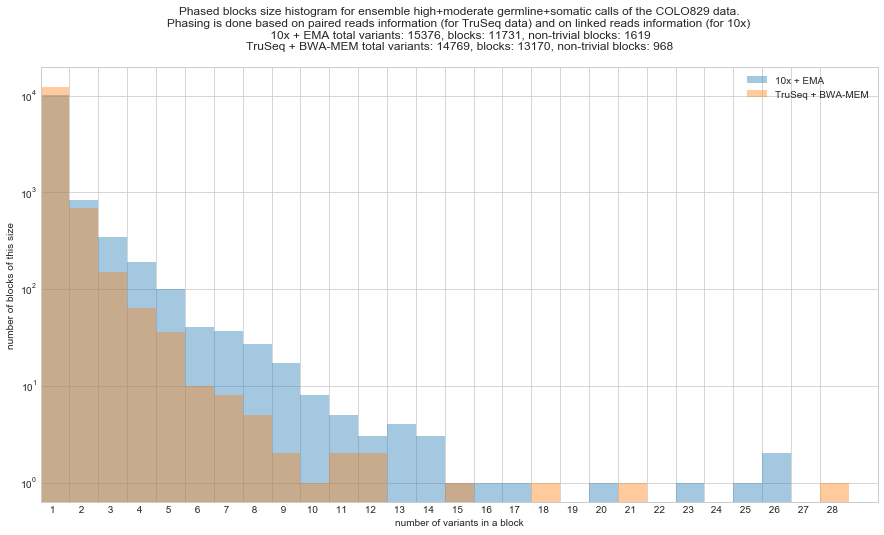

In [267]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

plt.figure(figsize=(15,8))
plt.yscale('log')

bin_num = max(ema_blocks[0], bwa_blocks[0])

for x, l in [(ema_blocks, "10x + EMA"), (bwa_blocks, "TruSeq + BWA-MEM")]:
    ax = sns.distplot(x, label=l, kde=False, bins=x[0] - 1)
#     ax = plt.hist(x, label=l, bins=x[0]+1)
#     ax.set_xticks(np.arange(0, bins, step=1))

#plt.xticks(np.arange(1, bin_num))
plt.xticks(np.arange(0, bin_num), [' '*9 + f'{x}' for x in range(bin_num)])
plt.xlim(1, bin_num + 1)

plt.xlabel('number of variants in a block')
plt.ylabel('number of blocks of this size')
plt.title(f'Phased blocks size histogram for ensemble high+moderate germline+somatic calls of the COLO829 data.\n'
          f'Phasing is done based on paired reads information (for TruSeq data) and on linked reads '
          f'information (for 10x)\n '
          f'10x + EMA total variants: {sum(ema_blocks)}, blocks: {len(ema_blocks)}, '
          f'non-trivial blocks: {len([b for b in ema_blocks if b != 1])}\n'
          f'TruSeq + BWA-MEM total variants: {sum(bwa_blocks)}, blocks: {len(bwa_blocks)}, '
          f'non-trivial blocks: {len([b for b in bwa_blocks if b != 1])}\n'
          )
plt.legend()
pass


# strelka2 somatic WGS

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


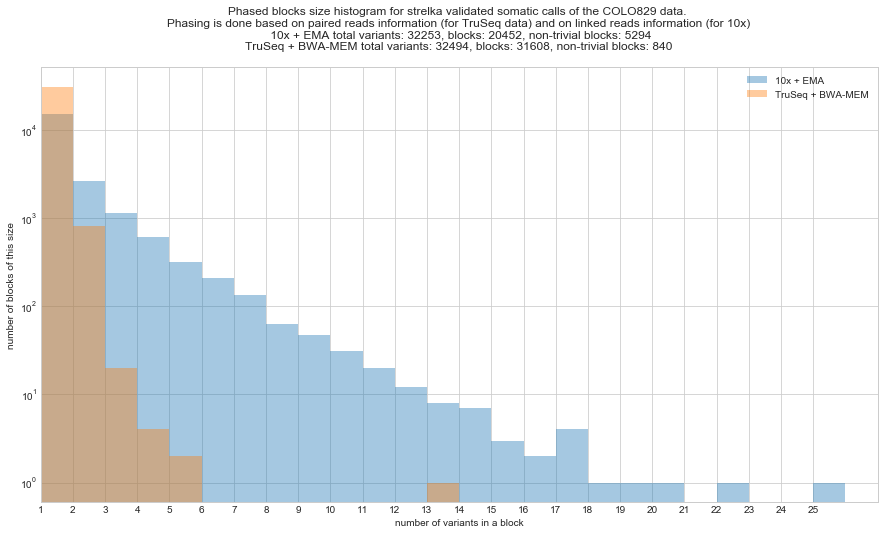

In [252]:
ema_blocks = parse_vcf_file('examples/somatic_EMA_100pc.phased.vcf')
bwa_blocks = parse_vcf_file('examples/somatic_BWA_100pc.phased.vcf')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

plt.figure(figsize=(15,8))
plt.yscale('log')

bin_num = max(ema_blocks[0], bwa_blocks[0])
plt.xticks(np.arange(bin_num))
plt.xlim(1, bin_num + 1)

for x, l in [(ema_blocks, "10x + EMA"), (bwa_blocks, "TruSeq + BWA-MEM")]:
    ax = sns.distplot(x, label=l, kde=False, bins=x[0]-1)

plt.xlabel('number of variants in a block')
plt.ylabel('number of blocks of this size')
plt.title(f'Phased blocks size histogram for strelka validated somatic calls of the COLO829 data. \n'
          f'Phasing is done based on paired reads information (for TruSeq data) and on linked reads '
          f'information (for 10x)\n '
          f'10x + EMA total variants: {sum(ema_blocks)}, blocks: {len(ema_blocks)}, '
          f'non-trivial blocks: {len([b for b in ema_blocks if b != 1])}\n'
          f'TruSeq + BWA-MEM total variants: {sum(bwa_blocks)}, blocks: {len(bwa_blocks)}, '
          f'non-trivial blocks: {len([b for b in bwa_blocks if b != 1])}\n'
          )
plt.legend()
pass
